In [1]:
import numpy as np
import quimb
import quimb.tensor as qtn

In [ ]:
# Create a random MPS state with 9 open indices and bond dimension 2
number_open_index = 9
bond_dimension =   2
psi = qtn.MPS_rand_state(L=number_open_index, bond_dim=bond_dimension)
#print(psi)

MatrixProductState([
    Tensor(shape=(2, 2), inds=('_a0834bAAGzd', 'k0'), tags=oset(['I0'])),
    Tensor(shape=(2, 2, 2), inds=('_a0834bAAGzd', '_a0834bAAGze', 'k1'), tags=oset(['I1'])),
    Tensor(shape=(2, 2, 2), inds=('_a0834bAAGze', '_a0834bAAGzf', 'k2'), tags=oset(['I2'])),
    Tensor(shape=(2, 2, 2), inds=('_a0834bAAGzf', '_a0834bAAGzg', 'k3'), tags=oset(['I3'])),
    Tensor(shape=(2, 2, 2), inds=('_a0834bAAGzg', '_a0834bAAGzh', 'k4'), tags=oset(['I4'])),
    Tensor(shape=(2, 2, 2), inds=('_a0834bAAGzh', '_a0834bAAGzi', 'k5'), tags=oset(['I5'])),
    Tensor(shape=(2, 2, 2), inds=('_a0834bAAGzi', '_a0834bAAGzj', 'k6'), tags=oset(['I6'])),
    Tensor(shape=(2, 2, 2), inds=('_a0834bAAGzj', '_a0834bAAGzk', 'k7'), tags=oset(['I7'])),
    Tensor(shape=(2, 2), inds=('_a0834bAAGzk', 'k8'), tags=oset(['I8'])),
], tensors=9, indices=17, L=9, max_bond=2)


In [ ]:
# Define a random 9-qubit bitstring we want to calculate loss for
bitstring = '101010101'
bitstring = np.array([int(x) for x in bitstring])
bitstring = qtn.MPS_computational_state(bitstring)
bitstring /= bitstring.H @ bitstring
# Reindexing:
rename_dict = {f'k{i}': f'k{i+9}' for i in range(9)}
bitstring.reindex_(rename_dict)
#print(bitstring)

MatrixProductState([
    Tensor(shape=(1, 2), inds=('_a0834bAAGyA', 'k9'), tags=oset(['I0'])),
    Tensor(shape=(1, 1, 2), inds=('_a0834bAAGyA', '_a0834bAAGyB', 'k10'), tags=oset(['I1'])),
    Tensor(shape=(1, 1, 2), inds=('_a0834bAAGyB', '_a0834bAAGyC', 'k11'), tags=oset(['I2'])),
    Tensor(shape=(1, 1, 2), inds=('_a0834bAAGyC', '_a0834bAAGyD', 'k12'), tags=oset(['I3'])),
    Tensor(shape=(1, 1, 2), inds=('_a0834bAAGyD', '_a0834bAAGyE', 'k13'), tags=oset(['I4'])),
    Tensor(shape=(1, 1, 2), inds=('_a0834bAAGyE', '_a0834bAAGyF', 'k14'), tags=oset(['I5'])),
    Tensor(shape=(1, 1, 2), inds=('_a0834bAAGyF', '_a0834bAAGyG', 'k15'), tags=oset(['I6'])),
    Tensor(shape=(1, 1, 2), inds=('_a0834bAAGyG', '_a0834bAAGyH', 'k16'), tags=oset(['I7'])),
    Tensor(shape=(1, 2), inds=('_a0834bAAGyH', 'k17'), tags=oset(['I8'])),
], tensors=9, indices=17, L=9, max_bond=1)


In [55]:
from scipy.special import comb

# Define the p_sigma coefficient
sigma = 0.09

# Define the set A of all possible bitstrings of lenght n and return the ones with norm l
def A(n,l):
    A = [np.array(list(bin(i)[2:].zfill(n)), dtype=int) for i in range(2**n)]
    A = [a for a in A if sum(a) == l]
    return A

In [60]:
# Define Dl string of observables
def Ommd(n, sigma):
    # Set parameters:
    n = 9             # number of qubits per half
    L = 2 * n         # total number of sites

    Dl_list = []
    # Questa è la sommatoria di tutti i Dl con il loro coefficiente coef1
    for l in range(1, n+1):
        p_sigma = (1 - np.exp(-1/(2*sigma)))/2
        coef = p_sigma**l * (1-p_sigma)**(n-l)

        A_l = A(n, l)

        # Building D2l
        mpo_list = []
        for i in A_l:
            site1 = i
            site2 = site1 + n

            # Define operators:
            Z = np.array([[1, 0],
                        [0, -1]])
            I = np.eye(2)

            # Build MPO tensors: each tensor is shaped (1, 1, 2, 2)
            mpo_tensors = []
            for site in range(L):
                # Choose Z on the designated sites, I elsewhere:
                op = Z if site in site1 or site in site2 else I
                tensor = op.reshape(1, 2, 2) if site in [0, L - 1] else op.reshape(1, 1, 2, 2)
                mpo_tensors.append(tensor)

            # Create the MPO. Here, 'sites' and 'L' help label the tensor network.
            mpo = qtn.MatrixProductOperator(
                mpo_tensors,
                sites=range(L),
                L=L,
                shape='lrud'
            )
            mpo_list.append(mpo)

        # Sum all the MPOs
        Dl = mpo_list[0]
        for i in mpo_list[1:]:
            Dl = Dl.add_MPO(i)
        
        Dl_list.append(coef*Dl)

    O = Dl_list[0]
    for i in Dl_list[1:]:
        Dl = Dl.add_MPO(i)
    
    return Dl

In [95]:
Omm = Ommd(2, 0.09)
Omm.show()

│503│503│503│503│503│503│503│503│503│503│503│503│503│503│503│503│503│
●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●
│   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │


In [79]:
print(Omm)

MatrixProductOperator([
    Tensor(shape=(503, 2, 2), inds=('_a0834bAAGud', 'k0', 'b0'), tags=oset(['I0'])),
    Tensor(shape=(503, 503, 2, 2), inds=('_a0834bAAGud', '_a0834bAAGue', 'k1', 'b1'), tags=oset(['I1'])),
    Tensor(shape=(503, 503, 2, 2), inds=('_a0834bAAGue', '_a0834bAAGuf', 'k2', 'b2'), tags=oset(['I2'])),
    Tensor(shape=(503, 503, 2, 2), inds=('_a0834bAAGuf', '_a0834bAAGug', 'k3', 'b3'), tags=oset(['I3'])),
    Tensor(shape=(503, 503, 2, 2), inds=('_a0834bAAGug', '_a0834bAAGuh', 'k4', 'b4'), tags=oset(['I4'])),
    Tensor(shape=(503, 503, 2, 2), inds=('_a0834bAAGuh', '_a0834bAAGui', 'k5', 'b5'), tags=oset(['I5'])),
    Tensor(shape=(503, 503, 2, 2), inds=('_a0834bAAGui', '_a0834bAAGuj', 'k6', 'b6'), tags=oset(['I6'])),
    Tensor(shape=(503, 503, 2, 2), inds=('_a0834bAAGuj', '_a0834bAAGuk', 'k7', 'b7'), tags=oset(['I7'])),
    Tensor(shape=(503, 503, 2, 2), inds=('_a0834bAAGuk', '_a0834bAAGul', 'k8', 'b8'), tags=oset(['I8'])),
    Tensor(shape=(503, 503, 2, 2), inds=('_

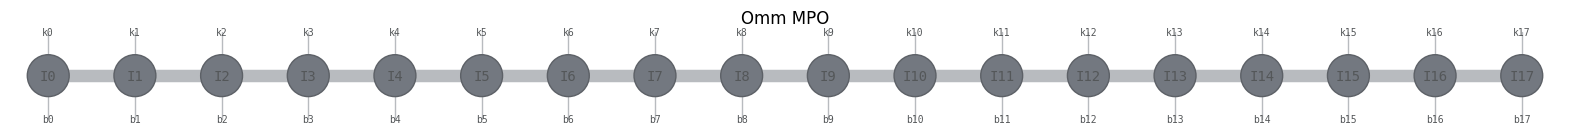

In [69]:
fix = {}
for i in range(L):
    fix["I{}".format(i)] = (i, 0)      # tensor node at site i
    fix["k{}".format(i)] = (i, 0.5)    # upper physical index above the tensor
    fix["b{}".format(i)] = (i, -0.5)   # lower physical index below the tensor

qtn.drawing.draw_tn(
    Omm,
    title = "Omm MPO",
    fix=fix, 
    layout='auto',  # fixed positions will be respected
    #color={'I': 'lightblue', 'Z': 'salmon'},
    figsize=(20, 4),
    show_inds=(1),
    show_tags=True
    )

In [96]:
psi_conj = psi.H
bitstring_conj = bitstring.H
# Reindexing:
rename_dict = {f'k{i}': f'b{i}' for i in range(9)}
psi_conj.reindex_(rename_dict)
rename_dict = {f'k{i}': f'b{i}' for i in range(9,18)}
bitstring_conj.reindex_(rename_dict)
print(psi_conj)
print(bitstring_conj)

MatrixProductState([
    Tensor(shape=(2, 2), inds=('_a0834bAAGzd', 'b0'), tags=oset(['I0'])),
    Tensor(shape=(2, 2, 2), inds=('_a0834bAAGzd', '_a0834bAAGze', 'b1'), tags=oset(['I1'])),
    Tensor(shape=(2, 2, 2), inds=('_a0834bAAGze', '_a0834bAAGzf', 'b2'), tags=oset(['I2'])),
    Tensor(shape=(2, 2, 2), inds=('_a0834bAAGzf', '_a0834bAAGzg', 'b3'), tags=oset(['I3'])),
    Tensor(shape=(2, 2, 2), inds=('_a0834bAAGzg', '_a0834bAAGzh', 'b4'), tags=oset(['I4'])),
    Tensor(shape=(2, 2, 2), inds=('_a0834bAAGzh', '_a0834bAAGzi', 'b5'), tags=oset(['I5'])),
    Tensor(shape=(2, 2, 2), inds=('_a0834bAAGzi', '_a0834bAAGzj', 'b6'), tags=oset(['I6'])),
    Tensor(shape=(2, 2, 2), inds=('_a0834bAAGzj', '_a0834bAAGzk', 'b7'), tags=oset(['I7'])),
    Tensor(shape=(2, 2), inds=('_a0834bAAGzk', 'b8'), tags=oset(['I8'])),
], tensors=9, indices=17, L=9, max_bond=2)
MatrixProductState([
    Tensor(shape=(1, 2), inds=('_a0834bAAGyA', 'b9'), tags=oset(['I0'])),
    Tensor(shape=(1, 1, 2), inds=('_a0834b

In [97]:
# Contract the MPO with the MPS and the bitstring
loss = psi & Omm & bitstring & psi_conj & bitstring_conj
loss = loss.contract(all, optimize='auto-hq')
print(loss)

-0.039292672557124236
